# Performance Gain 1: Hit-and-Run Uniform Slice Sampling
This experiment serves to showcase how much PATT can improve the performance of *hit-and-run uniform slice sampling* (HRUSS) ([MacKay et al. (2006)](https://www.inference.org.uk/itprnn/book.pdf), Section 29.7). Naturally, this is done by letting "plain" HRUSS compete with PATT-HRUSS on some fixed target, which for simplicity we chose to be a simple toy example.

Specifically, the target distribution we are considering in this experiment is $\nu = \mathcal{N}_d(0, \Sigma)$ with $\Sigma = \text{diag}(1^2,...,d^2)$, i.e. a mean-zero Gaussian with variables that are uncorrelated but have extremely inconsistent variances. This is, in a sense, a minimal example of where PATT can be helpful to HRUSS: As a variant of uniform slice sampling, HRUSS is insensitive to the absolute location of the target's probability mass, so that in particular its performance cannot be improved through *centering*. However, as HRUSS performs each iteration by taking a step along a line through the current state that is chosen uniformly at random, *variance adjustments* can already be helpful, as we will see below. Note that *covariance adjustments* should generally improve the performance of HRUSS even more than variance adjustments, as soon as the target's correlation structure is non-trivial.

In [1]:
path_prefix = "../plots/performance_gain_hruss_"

In [2]:
from patt_mcmc import patt_hruss
from hit_and_run_uniform_slice_sampling import parallel_hruss
import mcmc_utils as mcu
import plotting_functions as pfs
import numpy as np
import numpy.linalg as alg
import numpy.random as rnd
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
d = 50
n_chains = 10
n_burn = int(1e4)
n_its = int(4e4)
n_samples = n_chains * n_its
x_0s = rnd.normal(size=(n_chains,d))

In [4]:
std = np.arange(1, d+1)

def log_density(x):
    return -alg.norm(x / std)**2 / 2

### Run Plain HRUSS

In [5]:
w_plain = d

In [6]:
samples_tmp, tde_tmp, times_tmp = parallel_hruss(
    log_density,
    n_chains,
    n_burn + n_its,
    x_0s,
    w_plain,
)

Checking validity of given arguments...
Preparing for parallel sampling...
Starting parallel sampling...


100%|██████████████████████████████████| 50000/50000 [00:03<00:00, 14997.38it/s]


Processing returns and terminating...


In [7]:
burn_in_plain = samples_tmp[:n_burn+1]
burn_tde_plain = tde_tmp[:n_burn+1]
burn_times_plain = times_tmp[:n_burn+1]
samples_plain = samples_tmp[n_burn:]
tde_plain = tde_tmp[n_burn:]
times_plain = times_tmp[n_burn:]

### Run PATT-HRUSS

In [8]:
w_burn = d
w_att = np.sqrt(d) / 2

In [9]:
ret_dic = patt_hruss(
    log_density,
    n_chains,
    n_burn,
    n_its,
    x_0s,
    cov_mode="var",
    w_burn=w_burn,
    w_att=w_att,
)

Checking validity of given arguments...
Preparing for parallel sampling...
Preparing for init burn-in period...
Starting init burn-in sampling...
Preparing for ATT sampling...
Starting ATT sampling...


  0%|          | 0/40001 [00:00<?, ?it/s]

Assembling output...


In [10]:
burn_in_patt = ret_dic['burn-in']
burn_tde_patt = ret_dic['tde_cnts_burn']
burn_times_patt = ret_dic['runtimes_burn']
samples_patt = ret_dic['samples']
tde_patt = ret_dic['tde_cnts']
times_patt = ret_dic['runtimes']
means = ret_dic['means']
stds = ret_dic['std_devs']
schedule = ret_dic['schedule']

### Analyze Sampling Performance

In [11]:
snames = ["plain HRUSS", "PATT-HRUSS"]
burn_samples = [burn_in_plain, burn_in_patt]
burn_tde = [burn_tde_plain, burn_tde_patt]
burn_times = [burn_times_plain, burn_times_patt]
samples = [samples_plain, samples_patt]
tde = [tde_plain, tde_patt]
times = [times_plain, times_patt]

In [12]:
burn_radii = mcu.get_radii_list(burn_samples)
radii = mcu.get_radii_list(samples)
flat_steps = mcu.get_flat_steps_list(samples)

In [13]:
mean_burn_tde = mcu.mean_tde_list(burn_tde)
mean_tde = mcu.mean_tde_list(tde)
total_times = np.array([np.mean(np.sum(ts, axis=0)) for ts in times])
sams_per_s = n_samples / total_times
maxl = int(1e4)
mean_iats = mcu.mean_iat_multi_chain_list(samples, maxl)
msss = mcu.mss_list(samples)
tde_per_es = mean_tde * mean_iats # TDE/ES = total TDE / total ES = TDE/it / ES/it = TDE/it * IAT
es_per_s = sams_per_s / mean_iats # ES/s = total ES / total time = (total samples / IAT) / total time = samples/time / IAT

In [14]:
pd.DataFrame(
    np.array([
        snames,
        np.round(mean_burn_tde, 2),
        np.round(mean_tde, 2),
        np.array(sams_per_s, dtype=int),
        np.round(mean_iats, 2),
        np.round(msss, 2),
        np.round(tde_per_es, 2), 
        np.array(es_per_s, dtype=int), 
        np.round(mean_tde / msss, 2) # TDE/MSS = TDE/it * (its to move by 1) = TDE to move by 1
    ]).T,
    columns = [
        "Sampler",
        "TDE/it burn-in",
        "TDE/it",
        "Samples/s",
        "Mean IAT",
        "MSS",
        "TDE/ES",
        "ES/s",
        "TDE/MSS",
    ]
)

,Sampler,TDE/it burn-in,TDE/it,Samples/s,Mean IAT,MSS,TDE/ES,ES/s,TDE/MSS
0,plain HRUSS,5.1,5.1,163625,1315.88,7.32,6716.0,124,0.7
1,PATT-HRUSS,5.1,4.88,75539,104.43,30.91,510.16,723,0.16


We can see that PATT-HRUSS substantially outperforms HRUSS in the sample quality metrics, beating it by more than an order of magnitude in the mean IAT category and by a factor of around 4 in the MSS. Meanwhile, PATT appears to have little effect on the TDE/it (at least with the HRUSS hyperparameter choices we made). On the other hand, the PATT sampler only produces half as many samples per second as the plain sampler. Altogether, this leads to an improvement of over an order of magnitude in the cost-adjusted performance metric TDE/ES and an improvement by a somewhat smaller factor (roughly 6.5) in the likewise cost-adjusted metric ES/s.

One may ask why PATT-HRUSS has far higher autocorrelation here than PATT-GPSS would have in the same setting. As far as we can tell, this is the result of HRUSS being based on *uniform slice sampling*, which is known to suffer from a slight curse of dimensionality even for rotationally invariant log-concave targets (see e.g. [Roberts & Rosenthal (2002)](http://probability.ca/jeff/ftpdir/polar.pdf)), whereas GPSS is based on *polar slice sampling*, which under the same conditions is known to perform dimension-independently well ([Rudolf & Schär (2024)](https://doi.org/10.1007/s11222-023-10335-y)). As the sample quality, in the IAT sense, of uniform slice sampling appears to deteriorate proportionally to increasing dimension, one should expect a performance decrease by a factor of $50$ in the present, $d=50$ dimensional setting, compared with its performance in one dimension. This appears to explain the above mean IAT fairly well.

### Plotting

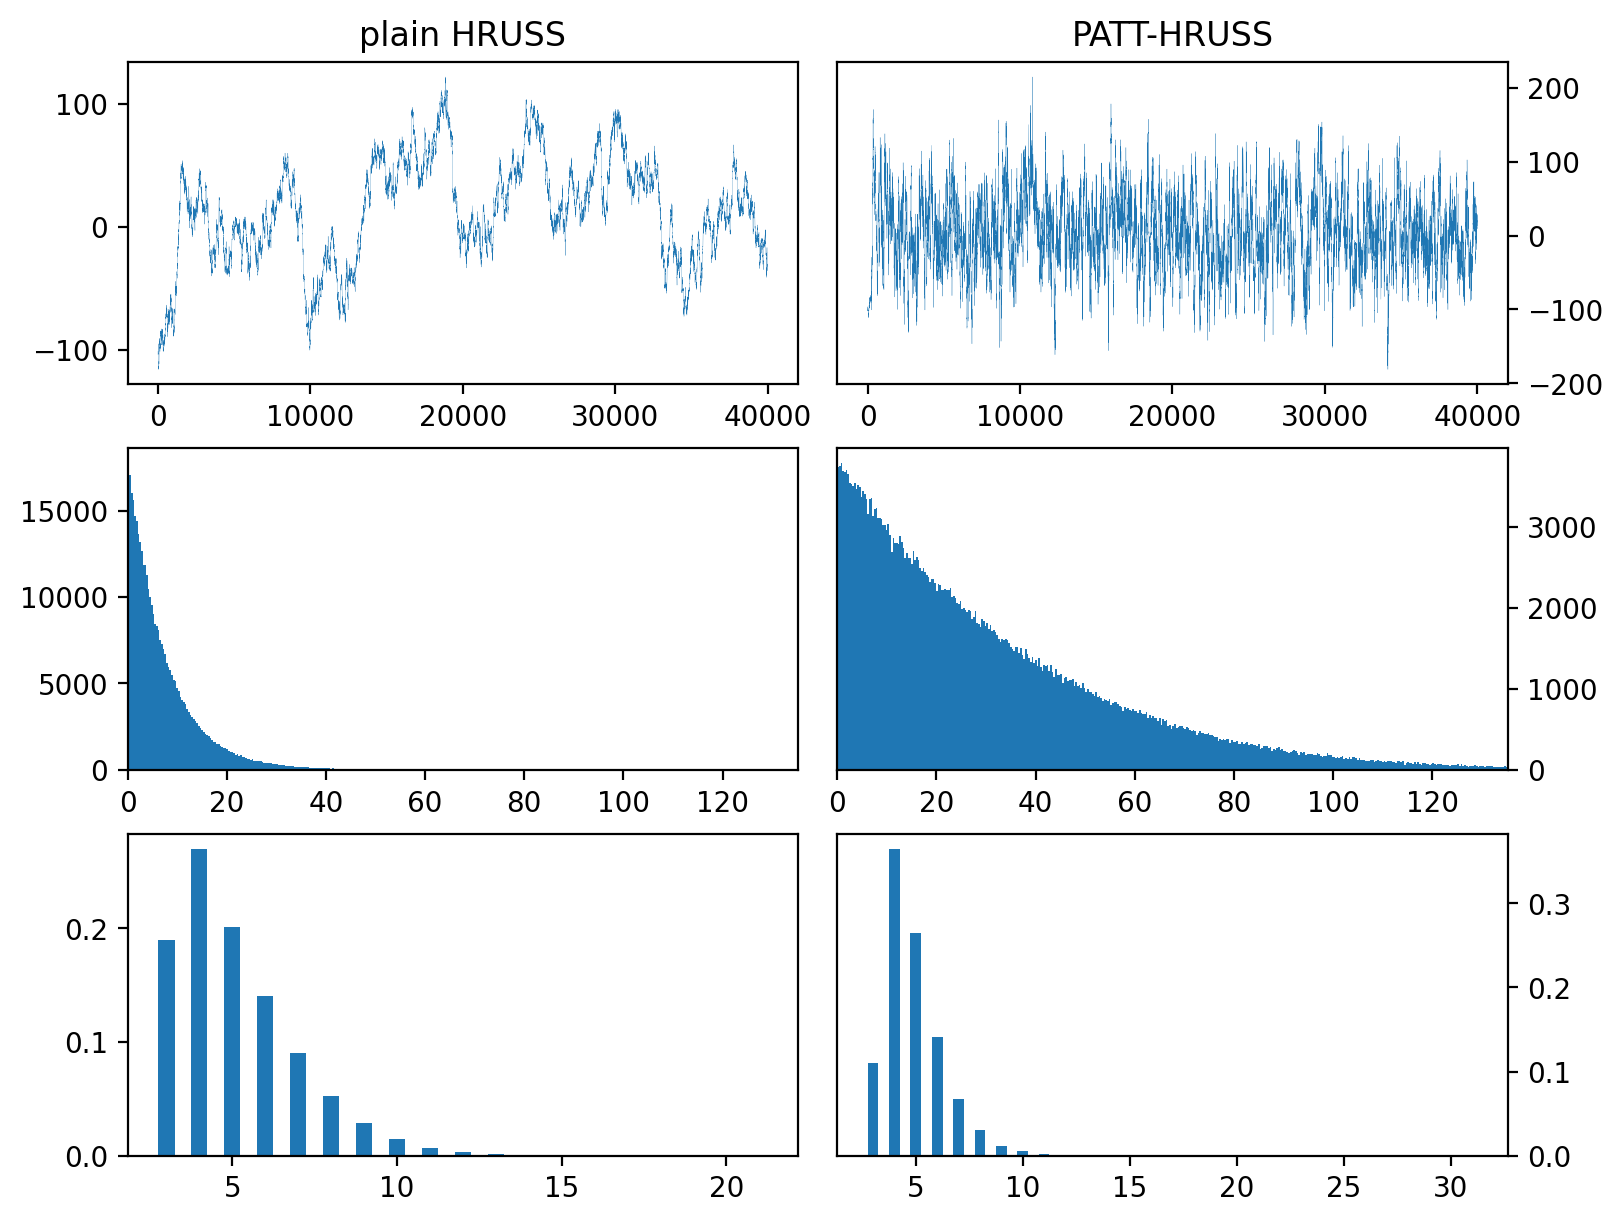

In [15]:
pfs.plot_trace_steps_tde(
    [sams[:,0,-1] for sams in samples],
    flat_steps,
    tde,
    snames,
    filepath = path_prefix + "overview.png",
    lws=0.1
)

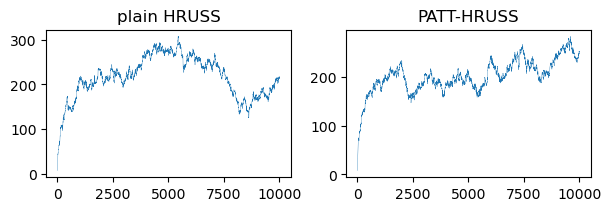

In [16]:
pfs.trace_plot_row([rs[:,0] for rs in burn_radii], snames, lws=0.25)

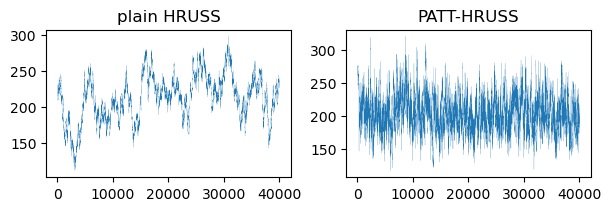

In [17]:
pfs.trace_plot_row([rs[:,0] for rs in radii], snames, lws=0.1)

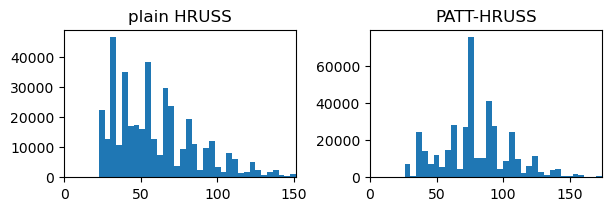

In [18]:
pfs.plot_runtime_hist_row(times, snames, cutoff_quant=0.99)

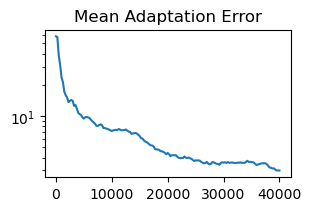

In [19]:
pfs.plot_ada_progress_testing(schedule, means, np.zeros(d), "Mean")

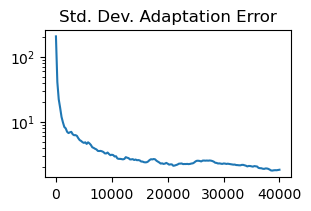

In [20]:
pfs.plot_ada_progress_testing(schedule, stds, std, "Std. Dev.")

From the above two plots we can see on the one hand that the adaptation continued to improve the transformation throughout the run, but on the other hand also that the adaptation error (i.e. the difference between the parameters in use and their asymptotic values) initially dropped very quickly, meaning that the parameters only needed a few update times to reach "good" values.